# 1. Importing Datasets/Libraries

In [1]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import numpy as np
#sns.set_style('darkgrid')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
#change wd
import os
os.chdir("C:/Users/annitan/Desktop/GA/DSIF-SG-7 - Copy/Project_2/data")

In [6]:
#importing datasets
#import train
train_dummified = pd.read_csv('train_dummified.csv')

#import test
test = pd.read_csv('test.csv')

#Change columns names to lowercase
train_dummified.columns = train_dummified.columns.str.lower().str.replace(' ', '_')
test.columns = test.columns.str.lower().str.replace(' ', '_')

## Train Test Split

In [7]:
#Define X and y
X = train_dummified.drop('saleprice', axis=1)
y = train_dummified[['saleprice']]

In [8]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
print("Shape of X_train:",X_train.shape,"\nShape of X_test:", X_test.shape )

Shape of X_train: (1634, 293) 
Shape of X_test: (409, 293)


In [9]:
from sklearn.preprocessing import RobustScaler
# Scale the independant feature cols
rs = RobustScaler()
X_train_scaled = rs.fit_transform(X_train)
X_test_scaled = rs.transform(X_test)

In [10]:
#Check the shapes
print(f'X_train_scaled shape is: {X_train_scaled.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'X_test_scaled shape is: {X_test_scaled.shape}')
print(f'y_test shape is: {y_test.shape}')

X_train_scaled shape is: (1634, 293)
y_train shape is: (1634, 1)
X_test_scaled shape is: (409, 293)
y_test shape is: (409, 1)


In [11]:
#Using linear regression as baseline
ols = LinearRegression()
ols_scores = cross_val_score(ols, X_train_scaled, y_train, cv=5)
print(ols_scores)
print(np.mean(ols_scores))

[0.91135588 0.91826432 0.87206369 0.87534293 0.91765283]
0.8989359313404487


In [12]:
# The mean R^2 is 0.89898. It's pretty high.

In [13]:
#Linear Regression with train-test-split
ols = LinearRegression()
#ols.fit(X_train, y_train)
ols.fit(X_train_scaled, y_train)
#preds = ols.predict(X_test)
preds = ols.predict(X_test_scaled)

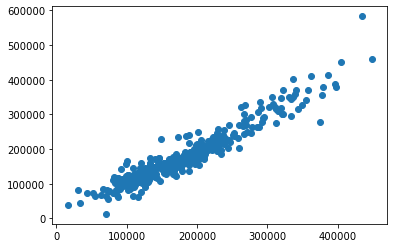

In [14]:
#Visualize the relationship between predicted and y_test
plt.scatter(preds, y_test)

In [15]:
# How does the model score on the training and test data?
print(ols.score(X_train_scaled, y_train))
print(ols.score(X_test_scaled, y_test))
#Rsquare is for train is higher than test, but they are relatively close.
#Based on Rsquare, our model is explaining around 90% variance in the Y data. 

0.9407168927771765
0.9120215898305426


In [16]:
# Check the MSE on the training and testing sets.

print(f'RMSE on training set: {mean_squared_error(y_train, ols.predict(X_train_scaled), squared = False)}')
print(f'RMSE on testing set: {mean_squared_error(y_test, preds, squared = False)}')

#Since RMSE of train set is less than RMSE of test set, our model is performing wrose on test set. 
#This means that it's likely that our model is overfitting. 

RMSE on training set: 19319.20917815542
RMSE on testing set: 22690.732480325525


## K Folds

In [155]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# iterate through folds 5-10
for folds in range(5,11):
    print ('------------------------------------\n')
    print ('K:', folds)
    model = LinearRegression()
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train_scaled, y_train, cv=folds)
    print ("Cross-validated scores:", scores)
    print ("Mean CV R2:", np.mean(scores))
    print ('Std CV R2:', np.std(scores))
    
    # Make cross-validated predictions
    predictions = cross_val_predict(model, X_train_scaled, y_train, cv=folds)
    
    r2 = metrics.r2_score(y_train, predictions)
    print ("Cross-Predicted R2:", r2)

------------------------------------

K: 5
Cross-validated scores: [0.91134311 0.91824875 0.87185136 0.87525695 0.91821657]
Mean CV R2: 0.8989833476537514
Std CV R2: 0.020942413995358546
Cross-Predicted R2: 0.9005363800248841
------------------------------------

K: 6
Cross-validated scores: [0.89782714 0.92116498 0.88992593 0.87926712 0.90685745 0.91607934]
Mean CV R2: 0.9018536602877515
Std CV R2: 0.014542870784024496
Cross-Predicted R2: 0.9032938946002556
------------------------------------

K: 7
Cross-validated scores: [0.90578796 0.90794972 0.9247662  0.86853011 0.85523939 0.91297536
 0.91493063]
Mean CV R2: 0.8985970501296631
Std CV R2: 0.024146680902801112
Cross-Predicted R2: 0.9000643321034191
------------------------------------

K: 8
Cross-validated scores: [0.89729257 0.91945175 0.9265433  0.88899908 0.87650135 0.86829737
 0.89631438 0.9317494 ]
Mean CV R2: 0.9006436497244429
Std CV R2: 0.021756623438432807
Cross-Predicted R2: 0.9025757110006617
----------------------------

K = 6 is ideal as it has the highest cross-predicted Rsquare (0.9032938946002556). 

Applying Ridge

In [156]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNet

In [157]:
%%time
ridge_alphas = np.logspace(0,5,200)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_scaled, y_train)

print(optimal_ridge.alpha_)

8.50448934180268
Wall time: 50.9 s


Cross Validate Ridge Rsquare with optimal alpha

In [158]:
ridge=Ridge(alpha = optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=10)
print(ridge_scores)
print(np.mean(ridge_scores))
#Ridge regression is performing better than Linear Regression

[0.90078847 0.91514998 0.91729719 0.93366442 0.87286247 0.88210447
 0.91565988 0.91090371 0.91961869 0.94117196]
0.9109221244487523


Optimal Lasso

In [159]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train_scaled, y_train)
print(optimal_lasso.alpha_)

C:\Users\ANNITAN\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

792.2876894817747


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.6s finished


Cross Val with Lasso

In [160]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

#Ridge performs slightly better than Lasso, but similar.

[0.88118116 0.90622435 0.91226071 0.90527691 0.84778163 0.86276131
 0.89063644 0.87844226 0.90464901 0.93067825]
0.8919892016331195


Look at coefficients for variables in Lasso

In [161]:
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=792.2876894817747)

In [162]:
lasso_coefs = pd.DataFrame({'variable': X_train.columns, 'coef':lasso.coef_, 'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.head(20)

,variable,coef,abs_coef
27,gr_liv_area,33924.636243,33924.636243
7,overall_qual,21151.193020,21151.193020
18,bsmtfin_sf_1,15719.569911,15719.569911
289,sale_type_New,13424.101105,13424.101105
12,exter_qual,13017.191810,13017.191810
22,total_bsmt_sf,9640.215670,9640.215670
34,kitchen_qual,9574.464310,9574.464310
9,year_built,8385.428760,8385.428760
78,neighborhood_NridgHt,7440.532618,7440.532618
11,mas_vnr_area,5970.331782,5970.331782


In [163]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0])*100)

Percent variables zeroed out: 12.481644640234949


ElasticNet Regression

In [164]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=100, verbose=1)
optimal_enet.fit(X_train_scaled, y_train)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio)

C:\Users\ANNITAN\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

792.2876894817747
[0.01    0.05125 0.0925  0.13375 0.175   0.21625 0.2575  0.29875 0.34
 0.38125 0.4225  0.46375 0.505   0.54625 0.5875  0.62875 0.67    0.71125
 0.7525  0.79375 0.835   0.87625 0.9175  0.95875 1.     ]


.......................................................................................................................................................................[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  3.6min finished


Comparing Ridge and Lasso regularized regressions

In [165]:
l1_ratios = np.linspace(0.01, 1.0, 25)

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet_scores = cross_val_score(enet, X_train_scaled, y_train, cv=10)

print(enet_scores)
print(np.mean(enet_scores)) 

#Ridge performs slightly better than Enet, but similar.

[0.88118116 0.90622435 0.91226071 0.90527691 0.84778163 0.86276131
 0.89063644 0.87844226 0.90464901 0.93067825]
0.8919892016331195
